In [1]:
# Mounting Google drive to save the dataset long-term
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip -q install kagglehub

In [ ]:
# Getting the dataset
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kmljts/reside-6k")

print("Path to dataset files:", path)

100%|██████████| 1.48G/1.48G [00:09<00:00, 169MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/kmljts/reside-6k/versions/1


In [ ]:
# Copy the dataset into Drive
import os, shutil

# Drive address
drive_address = "/content/drive/MyDrive/DeepLearning/dataset/reside-6k"
os.makedirs(drive_address, exist_ok=True)

for item in os.listdir(path):
  src = os.path.join(path, item)
  dst = os.path.join(drive_address, item)
  if os.path.isdir(src):
    shutil.copytree(src, dst, dirs_exist_ok=True)
  else:
    shutil.copy2(src, dst)

print("Copied dataset to the drive: ", drive_address)

Copied dataset to the drive:  /content/drive/MyDrive/DeepLearning/dataset/reside-6k


In [2]:
# Also need to copy the dataset from drive to local directory. Drive saves dataset long-term, but local fetching is faster
import shutil
import os

# source is drive, local is here
source_directory = "/content/drive/MyDrive/DeepLearning/dataset/reside-6k/RESIDE-6K"
local_directory = "/content/reside-6k-local"

print(f"Copying the data from Drive to {local_directory}")

# Check if the dataset is already in local directory. If yes, no need to copy it
if not os.path.exists(local_directory):
  shutil.copytree(source_directory, local_directory)
  print("Complete.")
else:
  print("Data already exists locally.")

DATA_ROOT = local_directory

# Defining directories for later use
TRAIN_HAZY = f"{DATA_ROOT}/train/hazy"
TRAIN_GT = f"{DATA_ROOT}/train/GT"
TEST_HAZY = f"{DATA_ROOT}/test/hazy"
TEST_GT = f"{DATA_ROOT}/test/GT"

Copying the data from Drive to /content/reside-6k-local
Complete.


In [13]:
# Normalization idea: convert image => tensor => normalize (for input)

import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import random
import torchvision.transforms.functional as TF
from torch.utils.data import random_split

# These values are used for normalization in FFA-Net training
MEAN = [0.64, 0.6, 0.58]
STD = [0.14, 0.15, 0.152]

# This class loads pairs of hazy-gt(clean) pictures one at a time, converts them to tensors, does normalization, and returns them
class ResidePairs(Dataset):
  def __init__(self, hazy_directory, gt_directory, is_train=True):
    self.hazy_directory = hazy_directory
    self.gt_directory = gt_directory
    # This variable ensures we don't augment test data, only train data
    self.is_train = is_train

    # Take all hazy and gt files from the dataset
    all_hazy_files = sorted([file for file in os.listdir(hazy_directory) if file.lower().endswith((".jpg", ".jpeg", ".png"))])
    gt_files = [file for file in os.listdir(gt_directory) if file.lower().endswith((".jpg", ".jpeg", ".png"))]

    # A map for image_id => actual_gt_filename
    self.gt_map = {os.path.splitext(file)[0]: file for file in gt_files}

    # Keep only those hazy files that have a matching GT (clear) file
    self.hazy_files = []
    for file in all_hazy_files:
      hazy_stem = os.path.splitext(file)[0]

      ID = hazy_stem.split("_")[0] # Getting the first name before underscore from the image name

      if ID in self.gt_map:
        self.hazy_files.append(file)
      elif hazy_stem in self.gt_map:
        self.hazy_files.append(file)
      else:
        print(f"This was an unmatched file. {file}")

    # Checking that all pairs matched (hazy, then gt)
    print(f"Found {len(self.hazy_files)} good pairs out of {len(all_hazy_files)} all hazy files.")

    # Normalization
    self.normalize = T.Normalize(mean=MEAN, std=STD)

  # Returns the number of hazy images
  def __len__(self): return len(self.hazy_files)

  # We define how to load one training example
  def __getitem__(self, index):
    hazy_file = self.hazy_files[index]
    hazy_path = os.path.join(self.hazy_directory, hazy_file)

    hazy_stem = os.path.splitext(hazy_file)[0] # convert "123_08.8.png" (for example) to "123.png"
    ID = hazy_stem.split("_")[0] # taking ID before the first underscore
    gt_filename = self.gt_map.get(ID, self.gt_map.get(hazy_stem))
    gt_path = os.path.join(self.gt_directory, gt_filename)

    # Conversion ensures every image is RGB
    hazy = Image.open(hazy_path).convert("RGB")
    gt = Image.open(gt_path).convert("RGB")

    # Resize
    hazy = TF.resize(hazy, [400, 400])
    gt = TF.resize(gt, [400, 400])

    # Augmentation (only needed for train data)
    if self.is_train:
      # Random horizontal flip
      if random.random() > 0.5:
        hazy = TF.hflip(hazy)
        gt = TF.hflip(gt)

      # Rotation
      angle = random.choice([0, 90, 180, 270])
      if angle > 0:
        hazy = TF.rotate(hazy, angle)
        gt = TF.rotate(gt, angle)

    # Conversion to tensor
    hazy = TF.to_tensor(hazy)
    gt = TF.to_tensor(gt)

    # Normalization (only for hazy images because we don't need to normalize outputs)
    hazy = self.normalize(hazy)

    return hazy, gt

# Split the train dataset into train/validation for graph visualizing
full_train_dataset = ResidePairs(TRAIN_HAZY, TRAIN_GT, is_train=True)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
test_dataset = ResidePairs(TEST_HAZY, TEST_GT, is_train=False)

# DataLoader helps load data in batches, shuffles the data (test doesn't need shuffle), and supports parallel loading
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2, pin_memory=True)

Found 6000 good pairs out of 6000 all hazy files.
Found 1000 good pairs out of 1000 all hazy files.


In [14]:
# Testing images after normalization

# x - hazy images, y - clean (target) images
x, y = next(iter(train_loader))
# x.min and x.max are the smallest and largest pixel values in the tensor
# we check these values because they need to be within range (negative, >1) for hazy and (0, 1) for GT after normalization
print("x (hazy) shape:", x.shape, "min/max:", x.min().item(), x.max().item())
print("y (GT) shape:", y.shape, "min/max:", y.min().item(), y.max().item())

x (hazy) shape: torch.Size([8, 3, 400, 400]) min/max: -4.543417453765869 2.763158082962036
y (GT) shape: torch.Size([8, 3, 400, 400]) min/max: 0.0 1.0


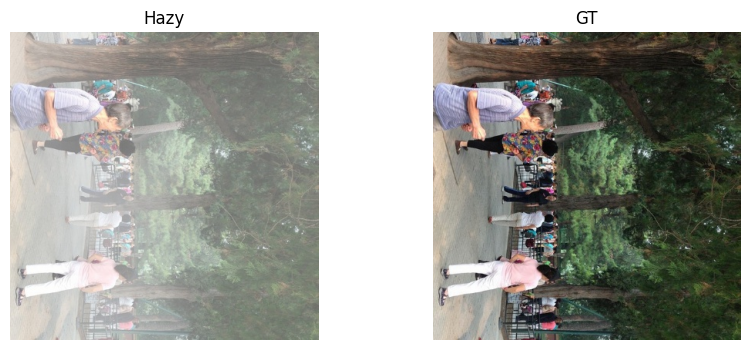

In [15]:
# Testing that dataset images are correct

import matplotlib.pyplot as plt
def unnormalize(img, mean=MEAN, std=STD):
  # This undoes the normalization that we did before so that we can view the image
  mean = torch.tensor(mean).view(3, 1, 1) # (3, 1, 1) is for (channel, height, width)
  std = torch.tensor(std).view(3, 1, 1)
  return (img * std + mean).clamp(0, 1) # after denormalizing some values might be out of range so we clamp them to (0, 1)

hazy, gt = train_dataset[559] # example
hazy_visual = unnormalize(hazy) # we only denormalize hazy images because clean (gt) images were never normalized in the first place

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1); plt.title("Hazy"); plt.imshow(hazy_visual.permute(1, 2, 0)); plt.axis("off")
plt.subplot(1, 2, 2); plt.title("GT"); plt.imshow(gt.permute(1, 2, 0)); plt.axis("off")
plt.show()

In [16]:
# Here we define the baseline model
import torch.nn as nn

# This class is for each individual residual block
class ResBlock(nn.Module):
  def __init__(self, channels):
    super(ResBlock, self).__init__()
    # Each residual block has three layers: Conv2D => ReLU => Conv2D
    self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
    self.relu = nn.ReLU(inplace=True)
    self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

  # This function tells us how the input is going to be processed through each block
  def forward(self, x):
    # Save the copy of the original input so that it's not lost
    residual = x
    # Passing the input through the main layers
    out = self.conv1(x)
    out = self.relu(out)
    out = self.conv2(out)
    # Takes the processed result and adds the original value to it
    out += residual
    return out

# This class is for the whole ResNet network
class VanillaResNet(nn.Module):
  def __init__(self, in_channels=3, out_channels=3, num_blocks=12, channels=64):
    super(VanillaResNet, self).__init__()

    # Takes raw 3-channel image and increases it to 48/64 channels (more channels are needed for more complex feature detection)
    self.head = nn.Conv2d(in_channels, channels, kernel_size=3, padding=1)

    # Using a loop to stack 12/16 residual blocks on each other to form a network
    self.body = nn.Sequential(*[ResBlock(channels) for _ in range(num_blocks)])

    # Reduces 48/64 channels back to 3 to get a normal image output
    self.tail = nn.Conv2d(channels, out_channels, kernel_size=3, padding=1)

  # Function that accepts input x and processes it with components from above
  def forward(self, x):
    x = self.head(x)
    x = self.body(x)
    x = self.tail(x)
    return x

# Getting the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Selecting the baseline model based on the number of residual blocks and channels
baseline_model = VanillaResNet(num_blocks=12, channels=64).to(device)

print(f"Baseline model was loaded on {device}")

Baseline model was loaded on cuda


In [17]:
# Here we train the baseline model that was just defined

import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define Loss and Optimizer
criterion = nn.L1Loss() # Loss (either L1 or L2, depending on configuration)
optimizer = optim.Adam(baseline_model.parameters(), lr=1e-4) # using Adam optimizer because it's the standard

# Training
epochs = 10

# Added to track losses for visual graph later
train_losses = []
val_losses = []

print("Starting Training...")

for epoch in range(epochs):
  baseline_model.train()
  running_loss = 0.0

  # For the progress bar, just for visualizing
  loop = tqdm(train_loader, leave=True)

  # This is where actual training logic happens
  for hazy_images, clean_images in loop:
    # This sends data (images) to GPU for fast processing
    hazy_images = hazy_images.to(device)
    clean_images = clean_images.to(device)

    # outputs is the model's guess of clear images
    outputs = baseline_model(hazy_images)
    # calculating loss
    loss = criterion(outputs, clean_images)

    # This clears old calculations
    optimizer.zero_grad()
    # Calculate the gradients
    loss.backward()
    # Here the optimizer updates the network's weights
    optimizer.step()

    # Updating progress bar
    running_loss += loss.item()
    loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
    loop.set_postfix(loss=loss.item())

  # Calculating training loss for the visual graph
  average_train_loss = running_loss / len(train_loader)
  train_losses.append(average_train_loss)

  # Validation
  baseline_model.eval()
  validation_loss = 0.0

  with torch.no_grad():
    # User images from validation dataset loaded earlier
    for hazy_images, clean_images in val_loader:
      # Use GPU, predict outputs, and calculate the val loss
      hazy_images = hazy_images.to(device)
      clean_images = clean_images.to(device)
      outputs = baseline_model(hazy_images)
      loss = criterion(outputs, clean_images)
      validation_loss += loss.item()

  # Calculating validation loss for the visual graph
  average_val_loss = validation_loss / len(val_loader)
  val_losses.append(average_val_loss)

  # By the end of each epoch:
  print(f"Epoch {epoch+1} finished with Average Loss: {running_loss/len(train_loader):.6f}")

# Save the model so that we don't lose progress. The name changes based on the parameters we used to train with
torch.save(baseline_model.state_dict(), "Resnet12_64_L1_Final.pth")
print("Baseline model saved!")

Starting Training...


Epoch [1/10]: 100%|██████████| 600/600 [02:06<00:00,  4.73it/s, loss=0.0895]


Epoch 1 finished with Average Loss: 0.105805


Epoch [2/10]: 100%|██████████| 600/600 [02:05<00:00,  4.77it/s, loss=0.0761]


Epoch 2 finished with Average Loss: 0.093843


Epoch [3/10]: 100%|██████████| 600/600 [02:05<00:00,  4.77it/s, loss=0.0968]


Epoch 3 finished with Average Loss: 0.090186


Epoch [4/10]: 100%|██████████| 600/600 [02:05<00:00,  4.77it/s, loss=0.101]


Epoch 4 finished with Average Loss: 0.087224


Epoch [5/10]: 100%|██████████| 600/600 [02:05<00:00,  4.77it/s, loss=0.0822]


Epoch 5 finished with Average Loss: 0.085644


Epoch [6/10]: 100%|██████████| 600/600 [02:05<00:00,  4.77it/s, loss=0.078]


Epoch 6 finished with Average Loss: 0.082792


Epoch [7/10]: 100%|██████████| 600/600 [02:05<00:00,  4.77it/s, loss=0.0719]


Epoch 7 finished with Average Loss: 0.080781


Epoch [8/10]: 100%|██████████| 600/600 [02:05<00:00,  4.77it/s, loss=0.0775]


Epoch 8 finished with Average Loss: 0.078948


Epoch [9/10]: 100%|██████████| 600/600 [02:05<00:00,  4.77it/s, loss=0.0716]


Epoch 9 finished with Average Loss: 0.076887


Epoch [10/10]: 100%|██████████| 600/600 [02:05<00:00,  4.77it/s, loss=0.0978]


Epoch 10 finished with Average Loss: 0.074736
Baseline model saved!


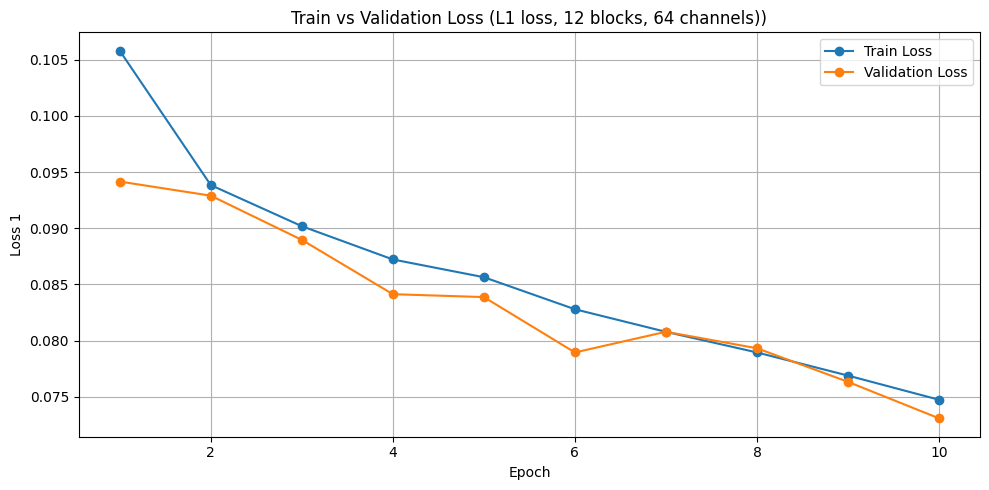

In [18]:
# Plotting the graph for visuals (train VS validation loss)
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss 1')
plt.title('Train vs Validation Loss (L1 loss, 12 blocks, 64 channels))')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('graph_loss_L1_12_64_final.png', dpi=150)
plt.show()

In [19]:
# After training the model, doing the evaluation

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import numpy as np

# First, convert tensor to images to display it properly
def tensor_to_image(tensor):
  # Move to CPU, detach from graph, convert to numpy, and change dimensions (channels, height, width => height, width, channels)
  image = tensor.cpu().detach().numpy().transpose(1, 2, 0)

  # Also, we need to compress the values back to [0, 1] range
  image = np.clip(image, 0, 1)
  return image

# The function to evaluate the model
def evaluating_model(model_path, model_name, blocks, channels):
  # Load the model
  model = VanillaResNet(num_blocks=blocks, channels=channels).to(device)

  # Loading the weights into the model
  model.load_state_dict(torch.load(model_path))
  # Freesing the model for testing
  model.eval()

  # Initialize the metrics
  average_psnr = 0.0
  average_ssim = 0.0
  count = 0

  print(f"Evaluating {model_name} on the test set")

  # This means the model must not learn at this moment
  with torch.no_grad():
    # Get hazy and clear images from the test set and move them to GPU
    for hazy, clear in test_loader:
      hazy = hazy.to(device)
      clear = clear.to(device)

      # Get the model's predictions for hazy test images
      outputs = model(hazy)

      # Calculate metrics for each image
      for i in range(hazy.size(0)):
        # Convert tensors (math) to images
        clear_image = tensor_to_image(clear[i])
        predicted_image = tensor_to_image(outputs[i])

        # Calculate metrics
        p = psnr(clear_image, predicted_image, data_range=1.0)
        s = ssim(clear_image, predicted_image, data_range=1.0, channel_axis=2)

        average_psnr += p
        average_ssim += s
        count += 1


  # Printing the results
  print(f"Results for {model_name}:")
  print(f"Average PSNR: {average_psnr/count:.4f} dB")
  print(f"Average SSIM: {average_ssim/count:.4f}")
  print()

# Running the evaluation on the trained model
evaluating_model("Resnet12_64_L1_Final.pth", "Baseline (L1, 12 blocks, 64 channels)", blocks=12, channels=64)

Evaluating Baseline (L1, 12 blocks, 64 channels) on the test set
Results for Baseline (L1, 12 blocks, 64 channels):
Average PSNR: 22.1485 dB
Average SSIM: 0.8570



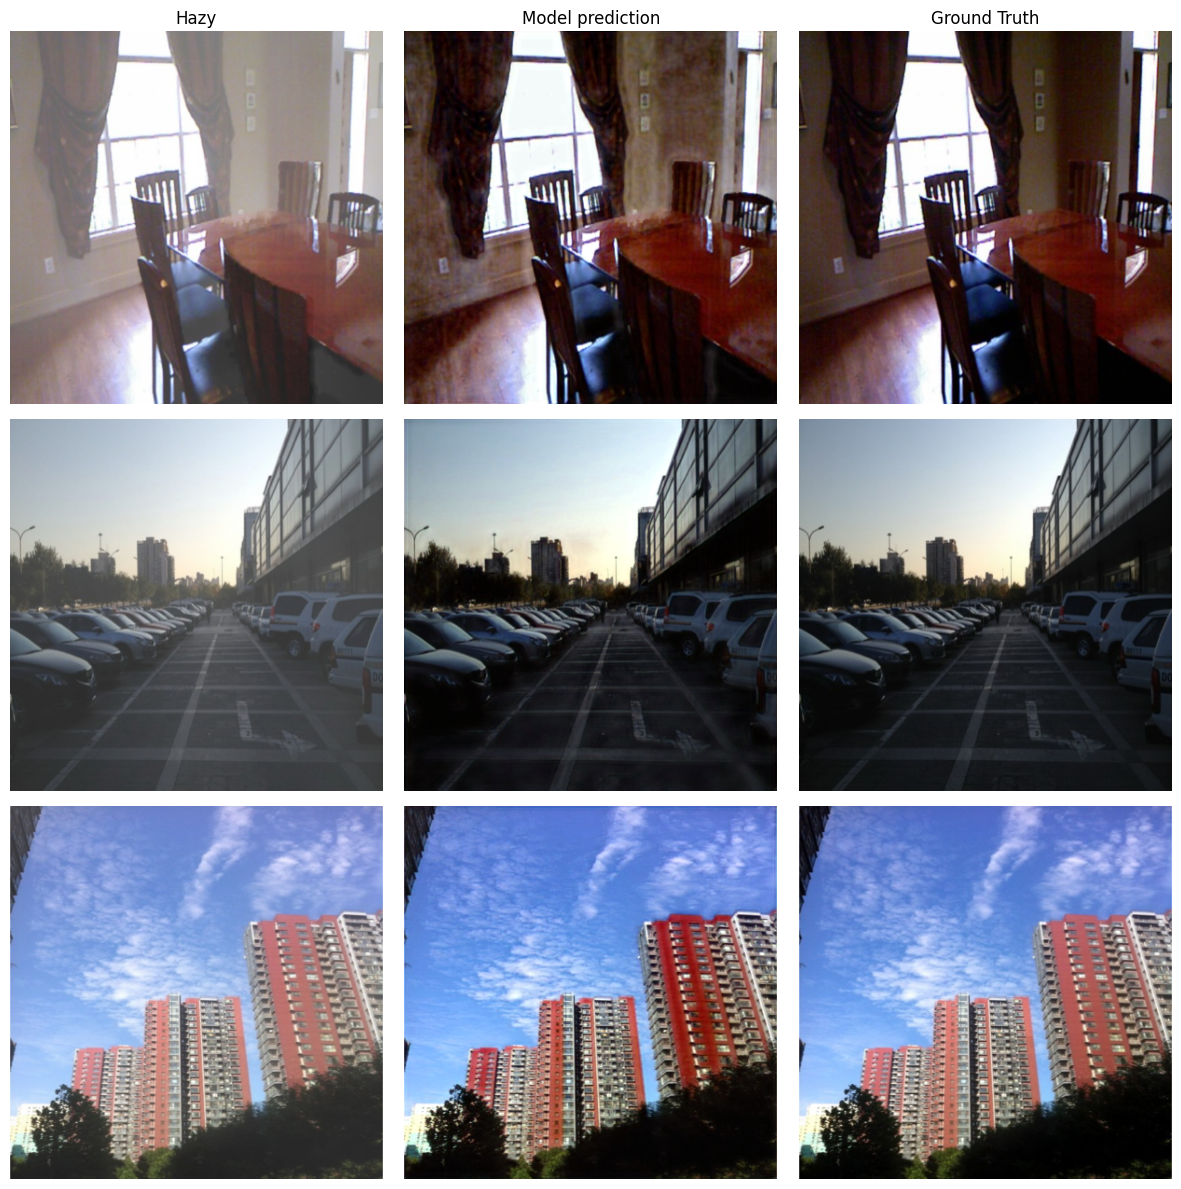

In [49]:
import matplotlib.pyplot as plt
import random

# Function to generate three images per example for hazy input, model's prediction, and ground truth
def examples(model_path, dataset, num_examples=3):
    # Load the model
    model = VanillaResNet(num_blocks=12, channels=64).to(device)
    # Loading the weights into the model
    model.load_state_dict(torch.load(model_path))
    # Freesing the model for testing
    model.eval()
    indexes = random.sample(range(len(dataset)), num_examples)

    # Figure settings
    fig, axes = plt.subplots(num_examples, 3, figsize=(12, 4*num_examples))
    columns = ['Hazy', 'Model prediction', 'Ground Truth']

    for column, title in enumerate(columns):
        axes[0][column].set_title(title, fontsize=12)

    # Making sure the model is not learning at the moment
    with torch.no_grad():
        for row, index in enumerate(indexes):
            hazy, gt = dataset[index] # get the pair of hazy/clean images from the dataset

            # Get model prediction
            hazy_input = hazy.to(device)
            output = model(hazy_input).clamp(0, 1)

            # Unnormalize hazy image for output
            mean = torch.tensor(MEAN).view(3, 1, 1)
            std = torch.tensor(STD).view(3, 1, 1)
            hazy_show = (hazy * std + mean).clamp(0, 1)

            # Convert to numpy
            hazy_image = hazy_show.permute(1, 2, 0).numpy()
            predicted_image = output.cpu().permute(1, 2, 0).numpy()
            gt_image = gt.permute(1, 2, 0).numpy()

            # Align the images in order
            for column, image in enumerate([hazy_image, predicted_image, gt_image]):
                axes[row][column].imshow(image)
                axes[row][column].axis('off')

    plt.tight_layout()
    plt.savefig('images_example.png', dpi=150, bbox_inches='tight')
    plt.show()

examples("Resnet12_64_L1_Final.pth", test_dataset, num_examples=3)